# Dynamic-DeepHit Tutorial

### by Changhee Lee

In [1]:
_EPSILON = 1e-08

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os

from sklearn.model_selection import train_test_split

import import_data_PBC as impt

from class_DeepLongitudinal import Model_Longitudinal_Attention

from utils_eval             import c_index, brier_score
from utils_log              import save_logging, load_logging
from utils_helper           import f_get_minibatch, f_get_boosted_trainset

In [2]:
def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)


def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):
    
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
       
    risk_all = {}
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return risk_all

### 1. Import Dataset
#####      - Users must prepare dataset in csv format and modify 'import_data.py' following our examplar 'PBC2'

In [3]:
data_mode                   = 'PBC2' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'PBC2':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = impt.import_dataset(norm_mode = 'standard')
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [52, 3*52, 5*52] # prediction time (in months)
    eval_time = [12, 36, 60, 120] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

### 2. Set Hyper-Parameters
##### - Play with your own hyper-parameters!

In [4]:
burn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32,

             'iteration_burn_in': 3000,
             'iteration': 25000,

             'keep_prob': 0.6,
             'lr_train': 1e-4,

             'h_dim_RNN': 100,
             'h_dim_FC' : 100,
             'num_layers_RNN':2,
             'num_layers_ATT':2,
             'num_layers_CS' :2,

             'RNN_type':'LSTM', #{'LSTM', 'GRU'}

             'FC_active_fn' : tf.nn.relu,
             'RNN_active_fn': tf.nn.tanh,

            'reg_W'         : 1e-5,
            'reg_W_out'     : 0.,

             'alpha' :1.0,
             'beta'  :0.1,
             'gamma' :1.0
}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim'         : x_dim,
                                'x_dim_cont'    : x_dim_cont,
                                'x_dim_bin'     : x_dim_bin,
                                'num_Event'     : num_Event,
                                'num_Category'  : num_Category,
                                'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'],
                                'h_dim_FC'          : new_parser['h_dim_FC'],
                                'num_layers_RNN'    : new_parser['num_layers_RNN'],
                                'num_layers_ATT'    : new_parser['num_layers_ATT'],
                                'num_layers_CS'     : new_parser['num_layers_CS'],
                                'RNN_type'          : new_parser['RNN_type'],
                                'FC_active_fn'      : new_parser['FC_active_fn'],
                                'RNN_active_fn'     : new_parser['RNN_active_fn'],
                                'initial_W'         : tf.contrib.layers.xavier_initializer(),

                                'reg_W'             : new_parser['reg_W'],
                                'reg_W_out'         : new_parser['reg_W_out']
                                 }


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### 3. Split Dataset into Train/Valid/Test Sets

In [5]:
### TRAINING-TESTING SPLIT
(tr_data, te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)

### 4. Train the Networ

In [6]:
##### CREATE DYNAMIC-DEEPFHT NETWORK
tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
losses = []
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)
        losses.append(loss_curr)
        
        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)
    losses.append(loss_curr)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)

        tmp_valid = np.mean(val_final1)

        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))

INFO:tensorflow:Scale of 0 disables regularizer.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.






BURN-IN TRAINING ...
itr: 1000 | loss: 234.7609
itr: 2000 | loss: 164.7771
itr: 3000 | loss: 160.6827
MAIN TRAINING ...
itr: 100

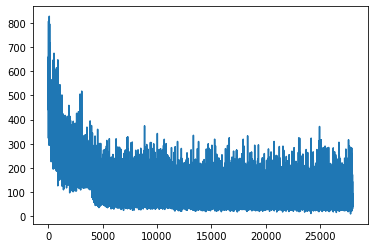

In [8]:
import matplotlib.pyplot as plt
plt.plot(losses)

### 5. Test the Trained Network

In [7]:
saver.restore(sess, file_path + '/model')

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

    for t, t_time in enumerate(eval_time):                
        eval_horizon = int(t_time) + pred_horizon
        for k in range(num_Event):
            result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
    if p == 0:
        final1, final2 = result1, result2
    else:
        final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
row_header = []
for p_time in pred_time:
    for t in range(num_Event):
        row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
col_header = []
for t_time in eval_time:
    col_header.append('eval_time {}'.format(t_time))

# c-index result
df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# brier-score result
df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

### PRINT RESULTS
print('========================================================')
print('--------------------------------------------------------')
print('- C-INDEX: ')
print(df1)
print('--------------------------------------------------------')
print('- BRIER-SCORE: ')
print(df2)
print('========================================================')

INFO:tensorflow:Restoring parameters from PBC2/model
--------------------------------------------------------
- C-INDEX: 
                        eval_time 12  eval_time 36  eval_time 60  \
pred_time 52: event_2       0.888430      0.846667      0.860000   
pred_time 52: event_2      -1.000000     -1.000000     -1.000000   
pred_time 156: event_2      0.929712      0.917098      0.893395   
pred_time 156: event_2      1.000000      0.818182      0.832168   
pred_time 260: event_2      0.836518      0.856688      0.841675   
pred_time 260: event_2      0.817204      0.801075      0.795699   

                        eval_time 120  
pred_time 52: event_2        0.886740  
pred_time 52: event_2        1.000000  
pred_time 156: event_2       0.877919  
pred_time 156: event_2       0.876344  
pred_time 260: event_2       0.833955  
pred_time 260: event_2       0.840637  
--------------------------------------------------------
- BRIER-SCORE: 
                        eval_time 12  eval_time 

In [8]:
pred_time = np.arange(3*52, 10*52)
eval_time = [1]

risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

In [9]:
from sksurv.metrics import brier_score
import matplotlib.pyplot as plt

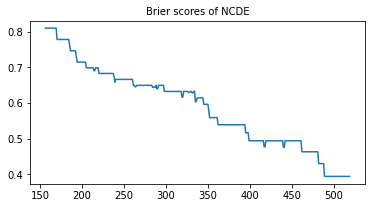

In [10]:
labels_test_structarray = []
for i in range(te_time.shape[0]):
    labels_test_structarray.append((bool(te_label[i]), te_time[i]))
labels_test_structarray = np.rec.array(labels_test_structarray, dtype=[('indic', bool), ('time', np.float32)])

_, brier_scores_test = brier_score(labels_test_structarray, labels_test_structarray, risk_all[1][:,:,0], pred_time)

_, ax = plt.subplots(figsize=(6,3))
ax.plot(pred_time, brier_scores_test)
plt.title("Brier scores of NCDE", size=10)
plt.show()